100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 22522.90it/s]


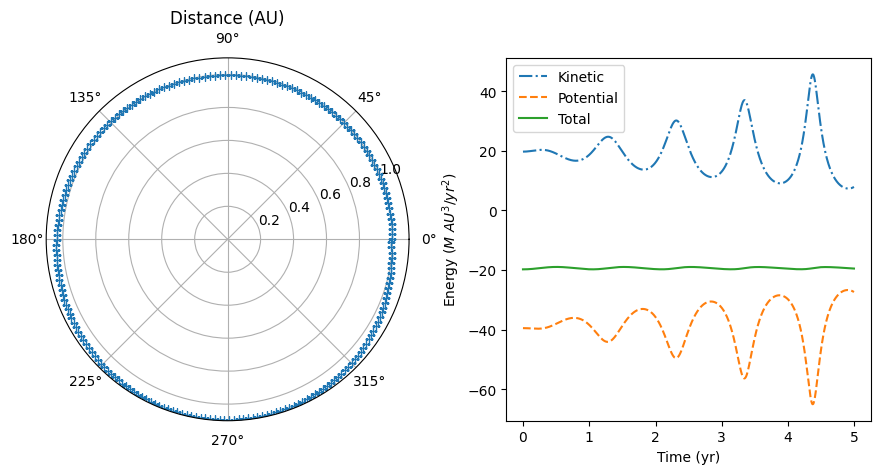

Period: 1.065 AU-yr
Semimajor axis: 1.018 AU
Perihelion: 1.036 AU
Eccentricity calculated: -0.018
Eccentricity theory: 0.146
6.28


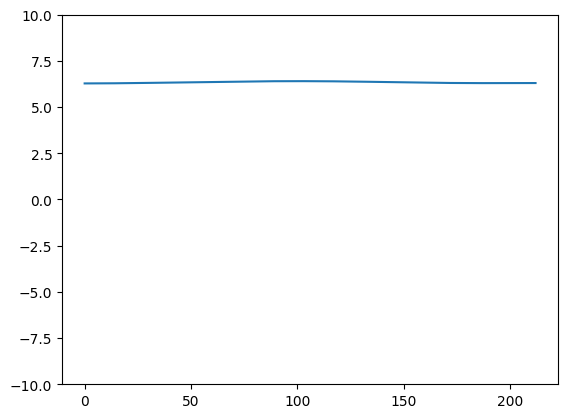

In [16]:
# orbit - Program to compute the orbit of a comet.

# Set up configuration options and special features
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from nm4p.rk4 import rk4
from nm4p.rka import rka

# Define gravrk function used by the Runge-Kutta routines
def gravrk(s, t, GM):
    """
    Returns the right-hand side of the Kepler ODE; used by Runge-Kutta routines
    :param s: State vector [r(0), r(1), v(0), v(1)]
    :param t: Time (not used here, included to match derivsRK input)
    :param GM: Parameter G*M - gravitational constant * solar mass Units [AU^3/yr^2]
    :return: deriv: Derivatives [dr(0/dt), dr(1)/dt, dv(0)/dt, dv(1)/dt]
    """

    # Compute acceleration
    r = s[:2]  # Unravel the vector s into position and velocity
    v = s[2:]
    accel = -GM * r / np.linalg.norm(r)**3  # Gravitational acceleration
    accel[0] -= perturbingForce
    # Return derivatives
    deriv = np.array([v[0], v[1], accel[0], accel[1]])

    return deriv


# Set initial position and velocity of the comet.
r0 = 1
v0 = 6.28
r = np.array([r0, 0.0])
v = np.array([0.0, v0])

state = np.array([r[0], r[1], v[0], v[1]])  # State used by R-K routines

# Set physical parameters
GM = 4 * np.pi**2  # Gravitational constant * Mass of sun [AU^3/yr^2]
mass = 1.0  # Mass of comet (reference mass)
adaptErr = 1.0E-3  # Error parameter used by adaptive Runge-Kutta
time = 0.0

# Perturbation

perturbingMass = GM # Using comet as reference mass
perturbingForce = .01*GM/r0**2

# Loop over the desired number of steps using the specified numerical method.
nStep = 1000
tau = .005
NumericalMethod = 3

rplot = np.empty(nStep)
thplot = np.empty(nStep)
tplot = np.empty(nStep)
vplot = np.empty(nStep)
kinetic = np.empty(nStep)
potential = np.empty(nStep)
stoplist = []


for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot[iStep] = np.linalg.norm(r)  # Record radial position and angle for polar plot
    thplot[iStep] = np.arctan2(r[1], r[0]) # domain is [-pi, pi]
    tplot[iStep] = time
    kinetic[iStep] = 0.5*mass*np.linalg.norm(v)**2  # Record kinetic and potential energy
    potential[iStep] = - GM*mass/np.linalg.norm(r)

    # Calculate new position and velocity using the desired method
    if NumericalMethod == 1:
        accel = -GM*r/np.linalg.norm(r)**3
        r += tau*v  # Euler Step
        v += tau*accel
        time += tau
    elif NumericalMethod == 2:
        accel = -GM * r / np.linalg.norm(r) ** 3
        v += tau * accel
        r += tau * v  # Euler-Cromer Step
        time += tau
    elif NumericalMethod == 3:
        state = rk4(state, time, tau, gravrk, GM)
        r = state[:2]  # 4th Order Runge-Kutta
        v = state[2:]
        vplot[iStep] = np.linalg.norm(v) 
        time += tau
    elif NumericalMethod == 4:
        state, time, tau = rka(state, time, tau, adaptErr, gravrk, GM)
        r = state[:2]  # 4th Order Runge-Kutta
        v = state[2:]
    else:
        raise ValueError('Invalid NumericalMethod input. Choose: 1) Euler; 2) Euler-Cromer; 3) Runge-Kutta; 4) Adaptive Runge-Kutta  ')
    # print(np.isclose(thplot[iStep],  3, rtol=1e-2, atol = 1e-2))
    if np.sign(thplot[iStep - 1]) - np.sign(thplot[iStep]) == -2:
        stoplist.append(iStep)

# Graph the trajectory  and energy of the comet over time.
totalE = kinetic + potential  # total energy

fig = plt.figure(figsize=(10.0, 5.25))
ax = fig.add_subplot(121, polar=True)
# ax.plot(thplot, rplot, '+',)
ax.plot(thplot[:stoplist[0]], rplot[:stoplist[0]], '+',)
ax.set_title('Distance (AU)')
# ax.set_rmax(2)

ax.grid(True)
fig.tight_layout(pad=5.0)

ax2 = fig.add_subplot(122)
ax2.plot(tplot, kinetic, ls='-.', label='Kinetic')
ax2.plot(tplot, potential, ls='--', label='Potential')
ax2.plot(tplot, totalE, ls='-', label='Total')
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel(r'Energy ($M~AU^3/yr^2$)')
ax2.legend()

plt.show()


period = stoplist[0] * tau
halfpind = int(stoplist[0] / 2)
semimajor = (rplot[stoplist[0]] + rplot[halfpind]) / 2

ecc = r0/semimajor - 1
perih = (1 - ecc)*semimajor

## Test program and compare measured eccentricity with predicted value
eTot = np.mean(totalE)
angMom = r0*v0
eccTh = np.sqrt(1 + 2*eTot*angMom**2/(GM**2)*mass**3)

print(f'Period: {period} AU-yr')
print(f'Semimajor axis: {semimajor:.3f} AU')
print(f'Perihelion: {perih:.3f} AU')
print(f'Eccentricity calculated: {ecc:.3f}')
print(f'Eccentricity theory: {eccTh:.3f}')

angMomPer = rplot*vplot
plt.figure()
# plt.plot(angMomPer)
plt.plot(angMomPer[:stoplist[0]])
plt.ylim([-10, 10])
print(angMom)